# Домашнее задание

## Задание 1

Проверьте поведение проделанных в ходе семинара трансформаций на датасете Smart-seq2. Какие выводы вы можете сделать?

## Решение

### Установка пакетов и импорт данных

Установим необходимые библиотеки

In [ ]:
!pip3 install scanpy[leiden] anndata2ri scikit-misc scvi-tools scvelo
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!pip install --upgrade --no-cache-dir gdown

!gdown --id 1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck
!tar xf library.tar.gz
!cp -r /content/usr/local/lib/R /usr/local/lib/
!rm -r usr

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

Установим R-magic

In [ ]:
import anndata2ri
anndata2ri.activate()
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
import rpy2

rpy2.__version__

'3.5.1'

Установка пакета glmGamPoi, необходимого для SCTransform

In [ ]:
!Rscript -e 'BiocManager::install("glmGamPoi")'

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.2 Patched (2022-11-10
  r83330)
Installing package(s) 'glmGamPoi'
trying URL 'https://bioconductor.org/packages/3.15/bioc/src/contrib/glmGamPoi_1.8.0.tar.gz'
Content type 'application/x-gzip' length 914728 bytes (893 KB)
downloaded 893 KB

* installing *source* package ‘glmGamPoi’ ...
** using staged installation
** libs
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I../inst/include/ -I'/usr/local/lib/R/site-library/Rcpp/include' -I'/usr/local/lib/R/site-library/RcppArmadillo/include' -I'/usr/local/lib/R/site-library/beachmat/include'    -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-ZLat0n/r-base-4.2.2.20221110=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c RcppExports.cpp -o RcppExports.o
g++ -std=gnu++11 -I"/usr/shar

Импортируем необходимые python библиотеки

In [ ]:
import scanpy as sc
import seaborn as sns
import scvelo as scv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("ticks")
sc.set_figure_params(dpi=150)

Скачаем Smart-seq2 данные 

In [ ]:
!gdown 1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg
!gdown 1n97r-ye38uOxAr5b424L3W3P4rwahJ3C

Downloading...
From: https://drive.google.com/uc?id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg
To: /content/PBMC_Satija.h5ad
100% 243M/243M [00:01<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n97r-ye38uOxAr5b424L3W3P4rwahJ3C
To: /content/Smart-seq2.h5ad
100% 20.8M/20.8M [00:00<00:00, 87.5MB/s]


Загрузим .h5ad в python

In [ ]:
adata_smart = sc.read_h5ad("Smart-seq2.h5ad")

В первую очередь создадим копию Smart-Seq2 данных

In [ ]:
adata_smart_raw = adata_smart.copy()

Импортируем функции из семинара для отрисовки графика

In [ ]:
def f_NB(x, a):
  return x + a * x**2

def mean_var_plot(adata, fit_NB=False, fit_poly=False, log=True,
                  xlim=None, ylim=None):
  from scipy.optimize import curve_fit

  variances = np.var(adata.X.A, axis=0)
  means = adata.X.mean(axis=0).A[0][variances > 0]
  variances = variances[variances > 0]
  lim_min = min(np.min(means), np.min(variances))
  lim_max = max(np.max(means), np.max(variances))
  fig, ax = plt.subplots(figsize=(4, 4))
  ax.plot([lim_min - 0.5, lim_max + 0.5], [lim_min - 0.5, lim_max + 0.5],
          linewidth=1, color="grey", label="$Var(E) = E$")
  sns.scatterplot(x=means, y=variances, ax=ax, linewidth=0, s=3)
  if fit_NB:
    popt_NB, _ = curve_fit(f_NB, means, variances)
    fit_line_NB = np.array(range(int(lim_max))) * 0.01
    ax.plot(fit_line_NB, f_NB(fit_line_NB, *popt_NB), color="red", 
            label="$Var(E) = E + ${:.2f}$E^2$".format(popt_NB[0]))
  ax.set_ylabel("Variance")
  ax.set_xlabel("Mean")
  if log:
    ax.set_xscale("log")
    ax.set_yscale("log")
  if not(xlim is None):
    ax.set_xlim(left=xlim[0], right=xlim[1])
  else:
    ax.set_xlim(left=0, right=lim_max)
  if not(ylim is None):
    ax.set_ylim(bottom=ylim[0], top=ylim[1])
  else:
    ax.set_ylim(bottom=0, top=lim_max)
  ax.legend()

### Трансформация данных

#### Сырые данные (без трансформаций)



Посмотрим, как распределены данные без трансформаций

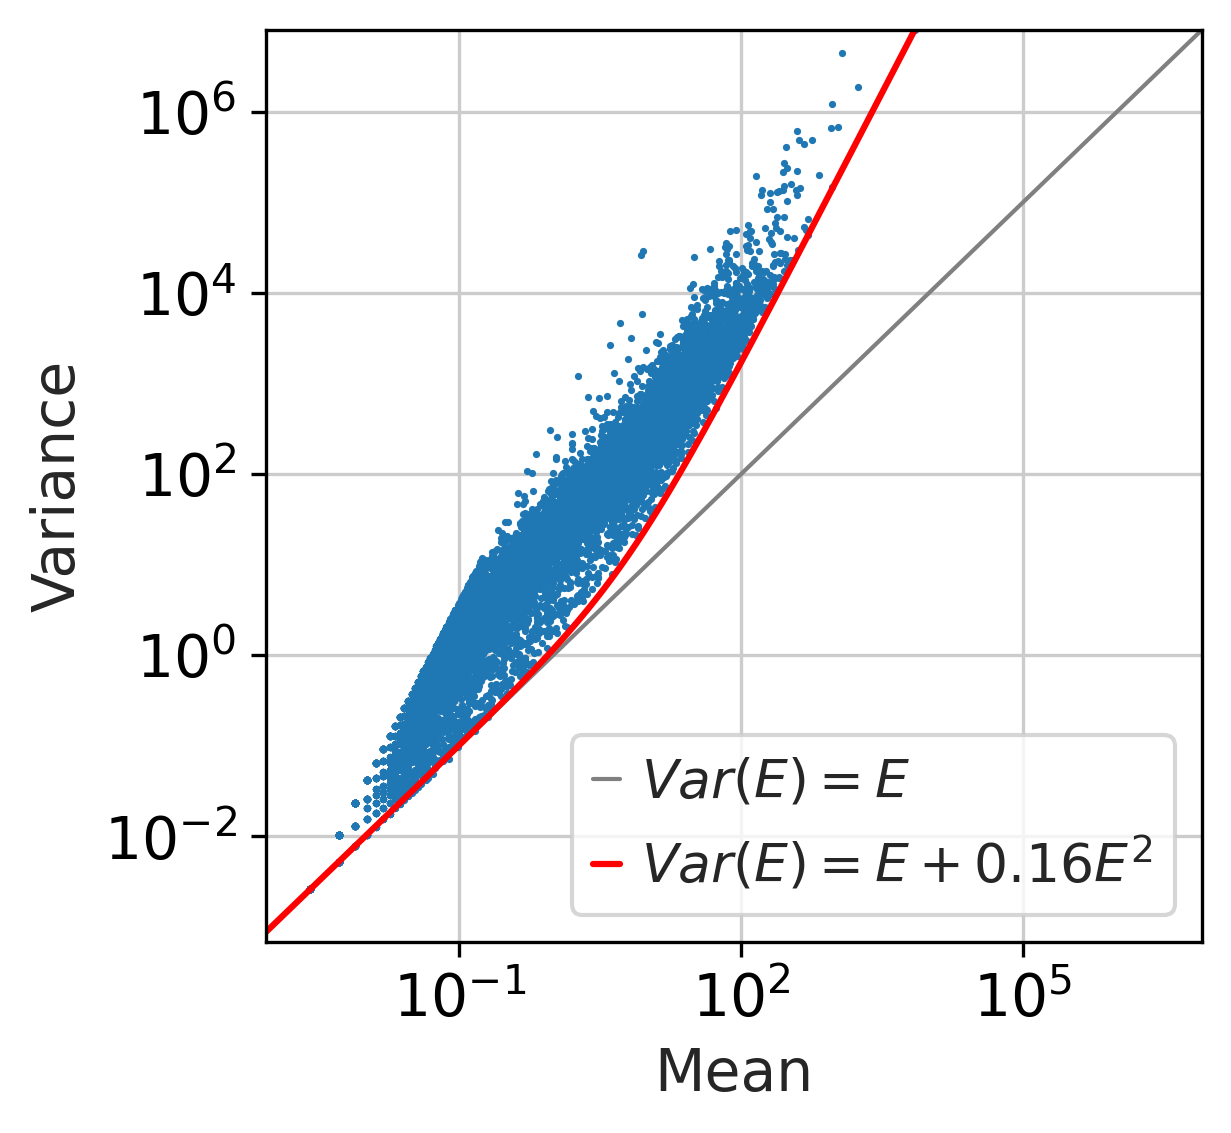

In [ ]:
mean_var_plot(adata_smart_raw, log=True, fit_NB=True)

По графику можно увидеть, что овердисперсия наблюдается даже у самых первых генов. Распределение Пуассона точно подходит к нашим данным.

#### CP10k трансформация

Данный метод должен убрать проблему глубины секвенирования библиотеки.

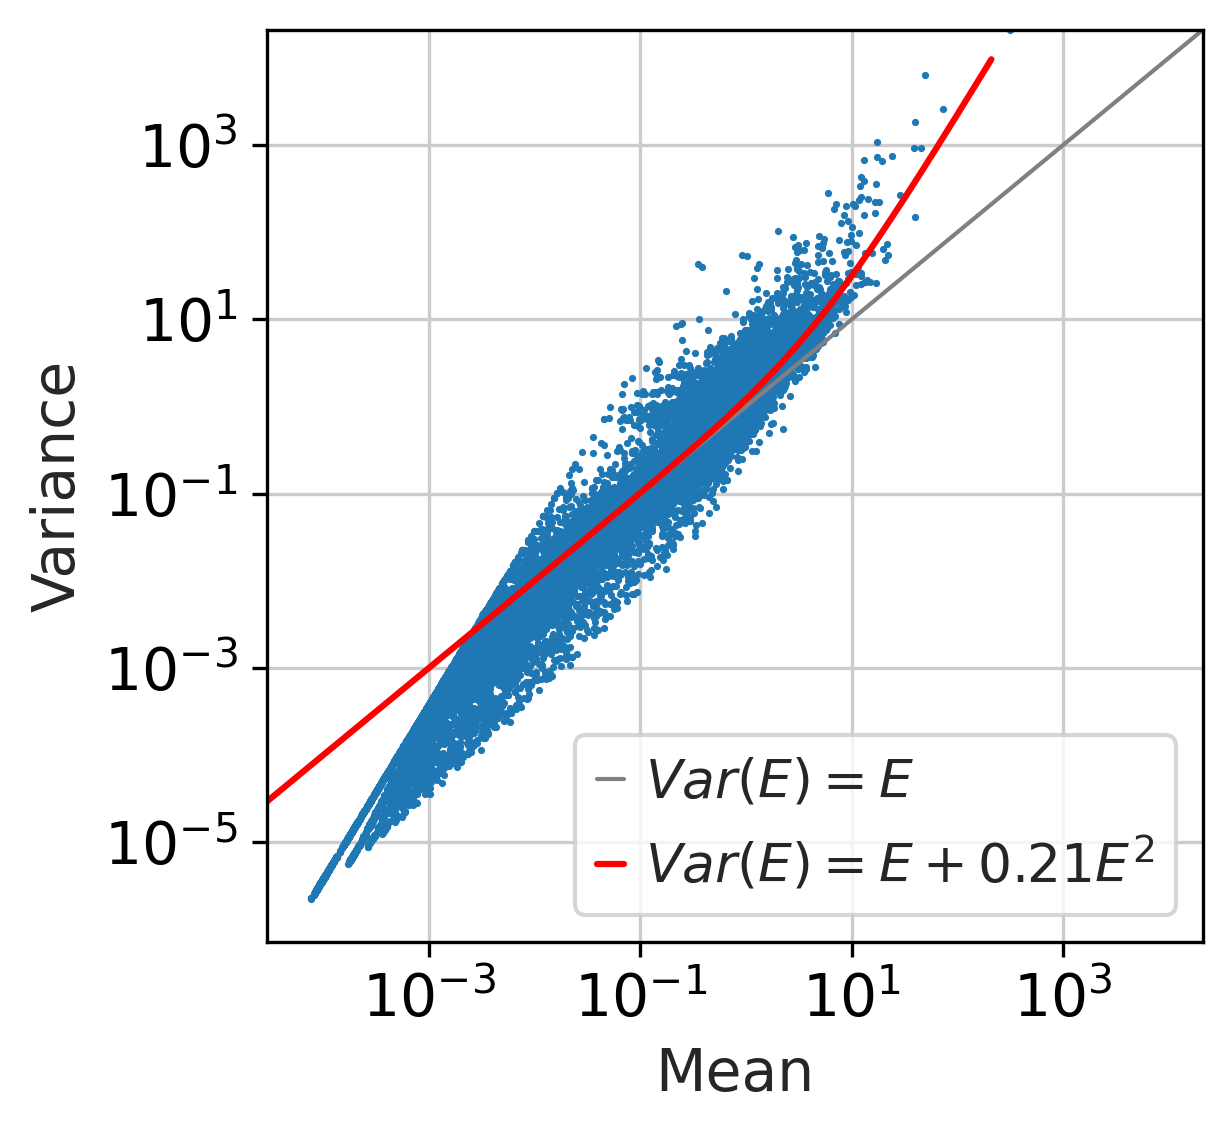

In [ ]:
adata = adata_smart_raw.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
mean_var_plot(adata, log=True, fit_NB=True)

Стало лучше, чем без трансформации. Попробуем другие методы трансформации.

#### Log трансформация

Теперь попробуем трансформацию логарифмированием

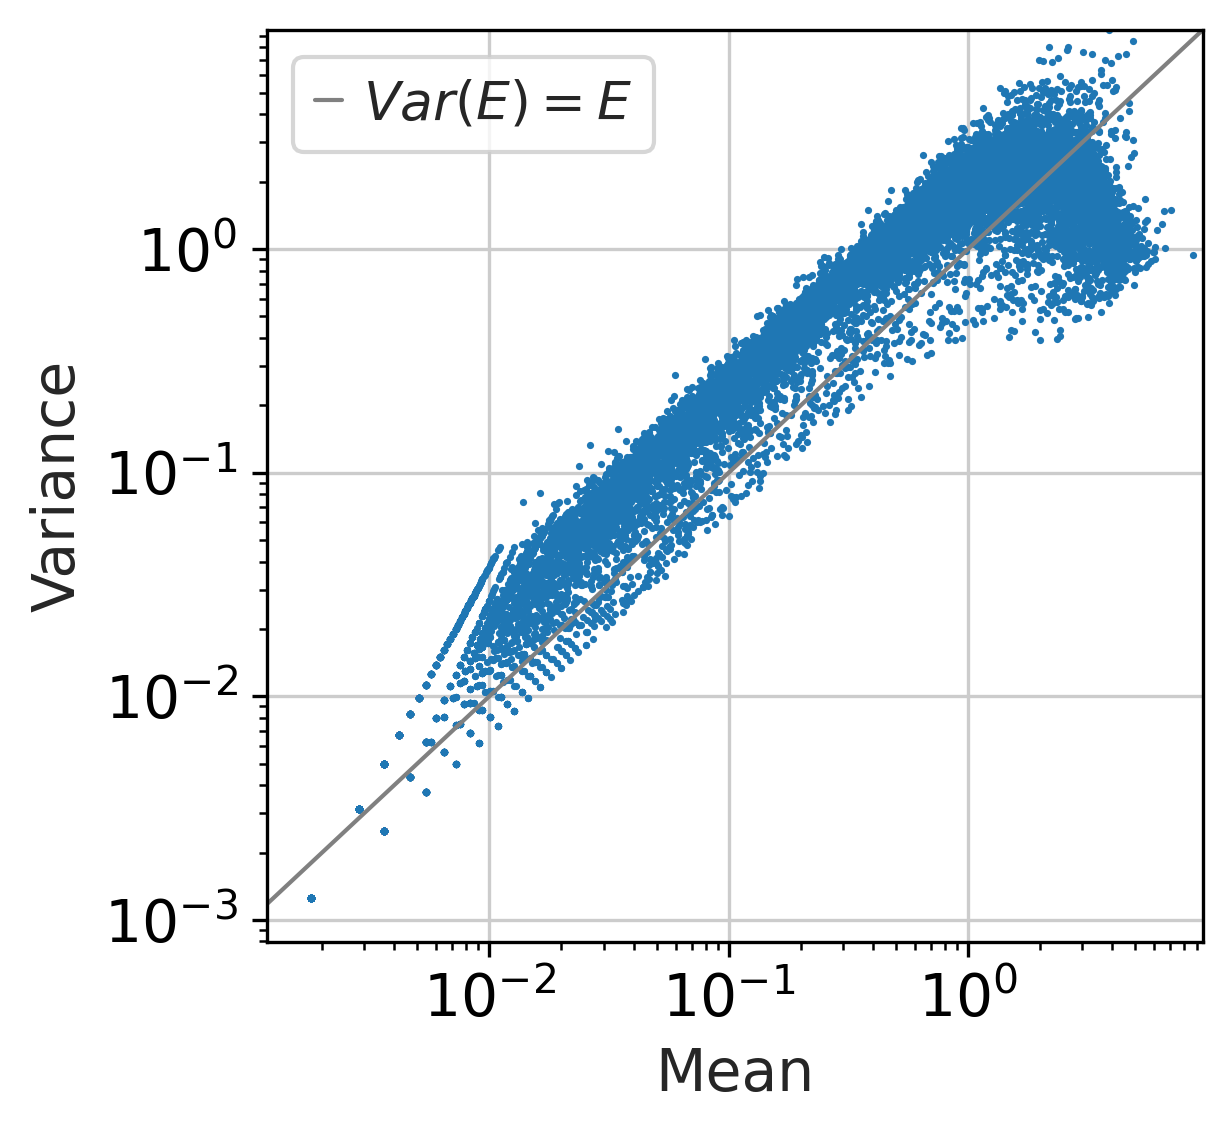

In [ ]:
adata_smart = adata_smart_raw.copy()
sc.pp.log1p(adata_smart)
mean_var_plot(adata_smart, log=True)

В данном случае мы получили плохой результат. У высокоэкспрессированных генов наблюдается андердисперсия (дисперсия меньше среднего значения)

#### Log + CP10k трансформация

Попробуем сначала найти CP10k (аналог CPM, только на 10000), затем логарифмируем и построим график:

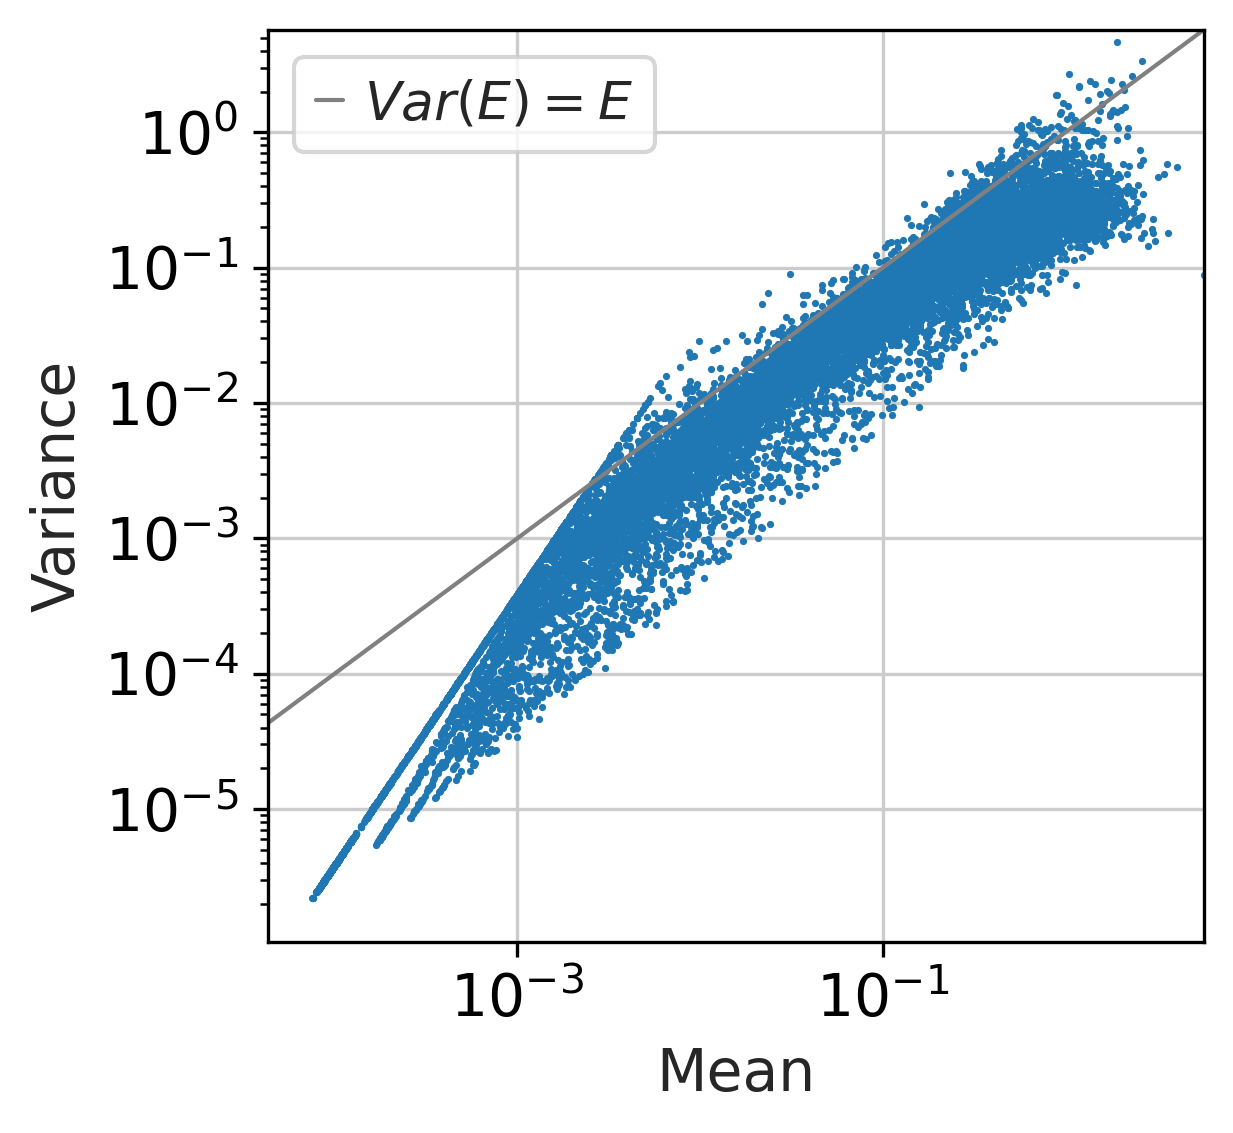

In [ ]:
adata_smart = adata_smart_raw.copy()
sc.pp.normalize_total(adata_smart, target_sum=1e4)
sc.pp.log1p(adata_smart)
mean_var_plot(adata_smart, log=True)

Получили результат лучше, чем в предыдущем случае. При этом овердисперсия пропала и у высокоэкспрессируемых генов наблюдается дисперсия ниже среднего значения (андердисперсия или underdispersion).

#### Sqrt трансформация

Теперь попробуем трансформацию квадратным корнем

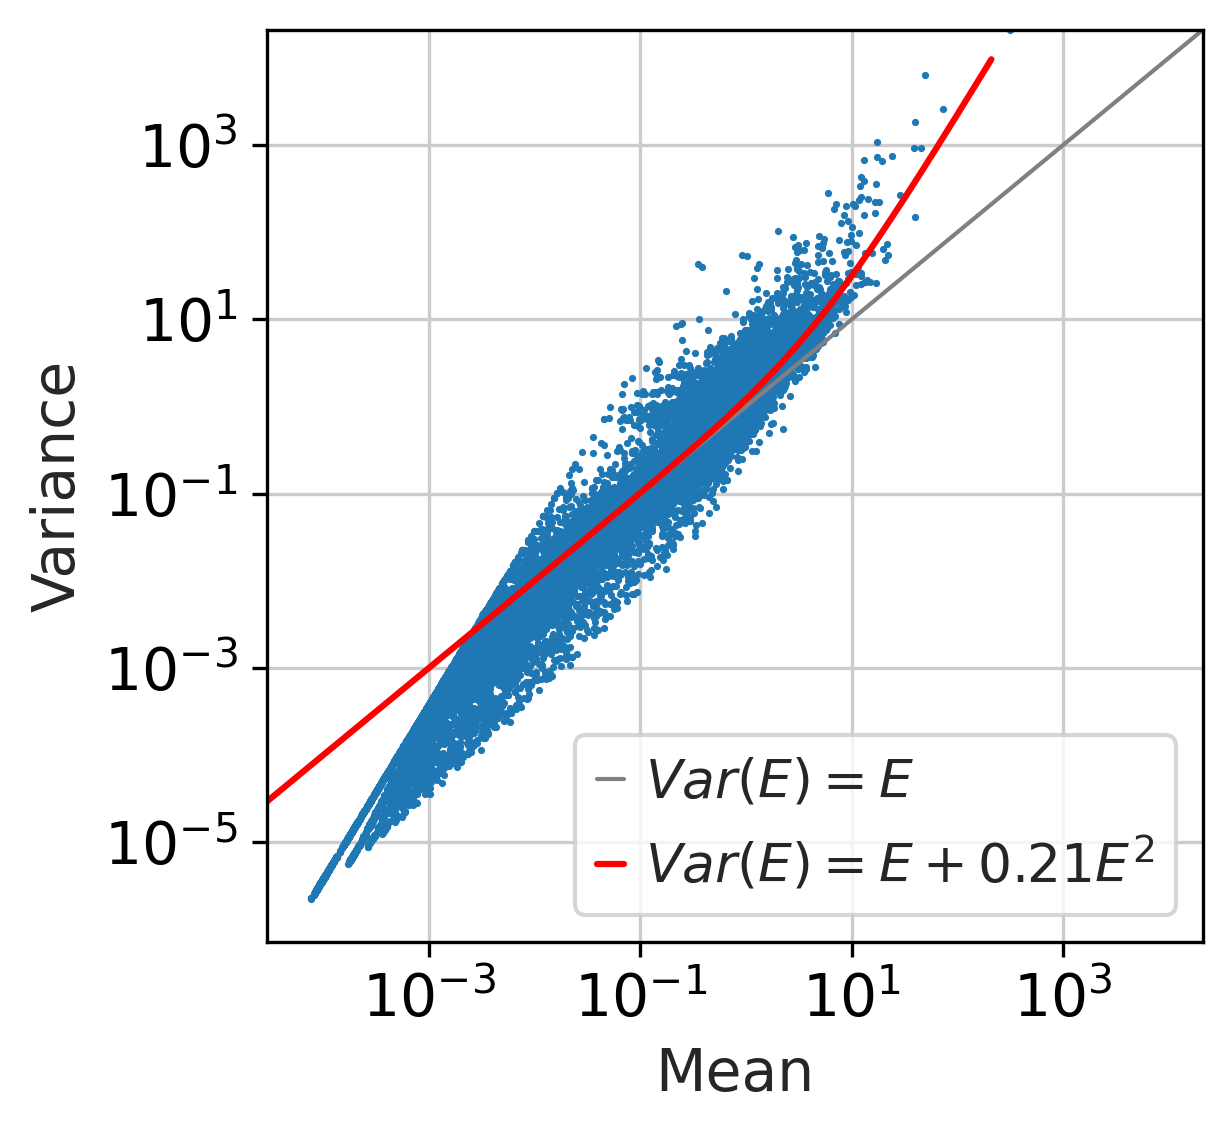

In [ ]:
adata_smart = adata_smart_raw.copy()
sc.pp.sqrt(adata_smart)
mean_var_plot(adata, log=True, fit_NB=True)

Получили плохой результат. Наблюдается сильная овердисперсия у высокоэкспрессируемых генов.

#### Sqrt + СP10K трансформация

Попробуем трансформацию квадратным корнем с CP10k.

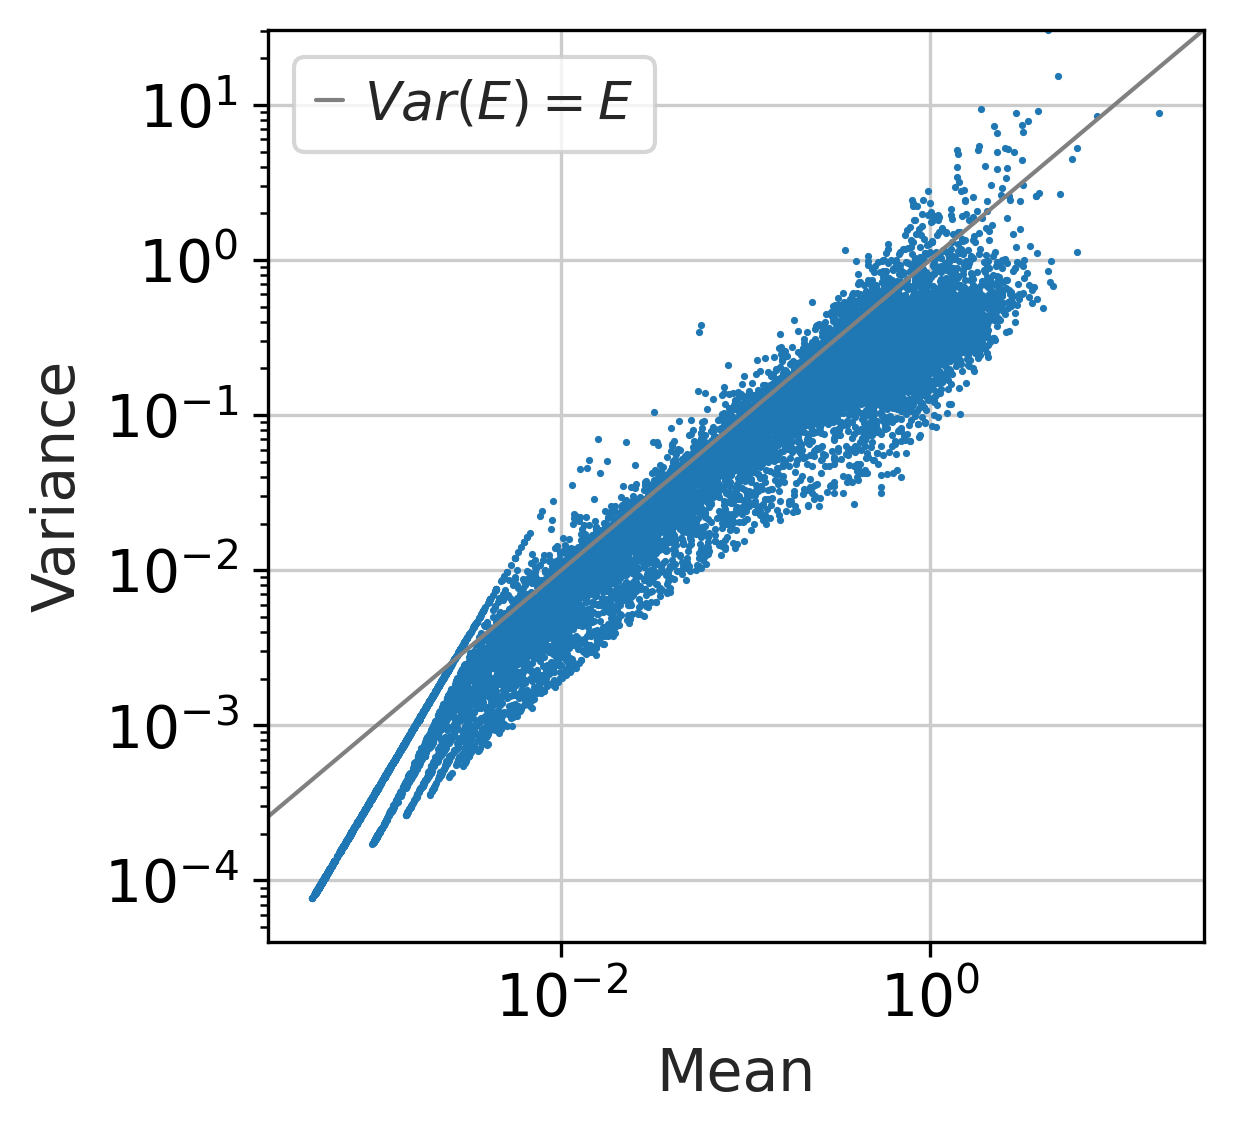

In [ ]:
adata = adata_smart_raw.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.sqrt(adata)
mean_var_plot(adata, log=True)

Получили примерно такой же результат, как и в случае log + CP10k.

#### Трансформация PFlog1pPF

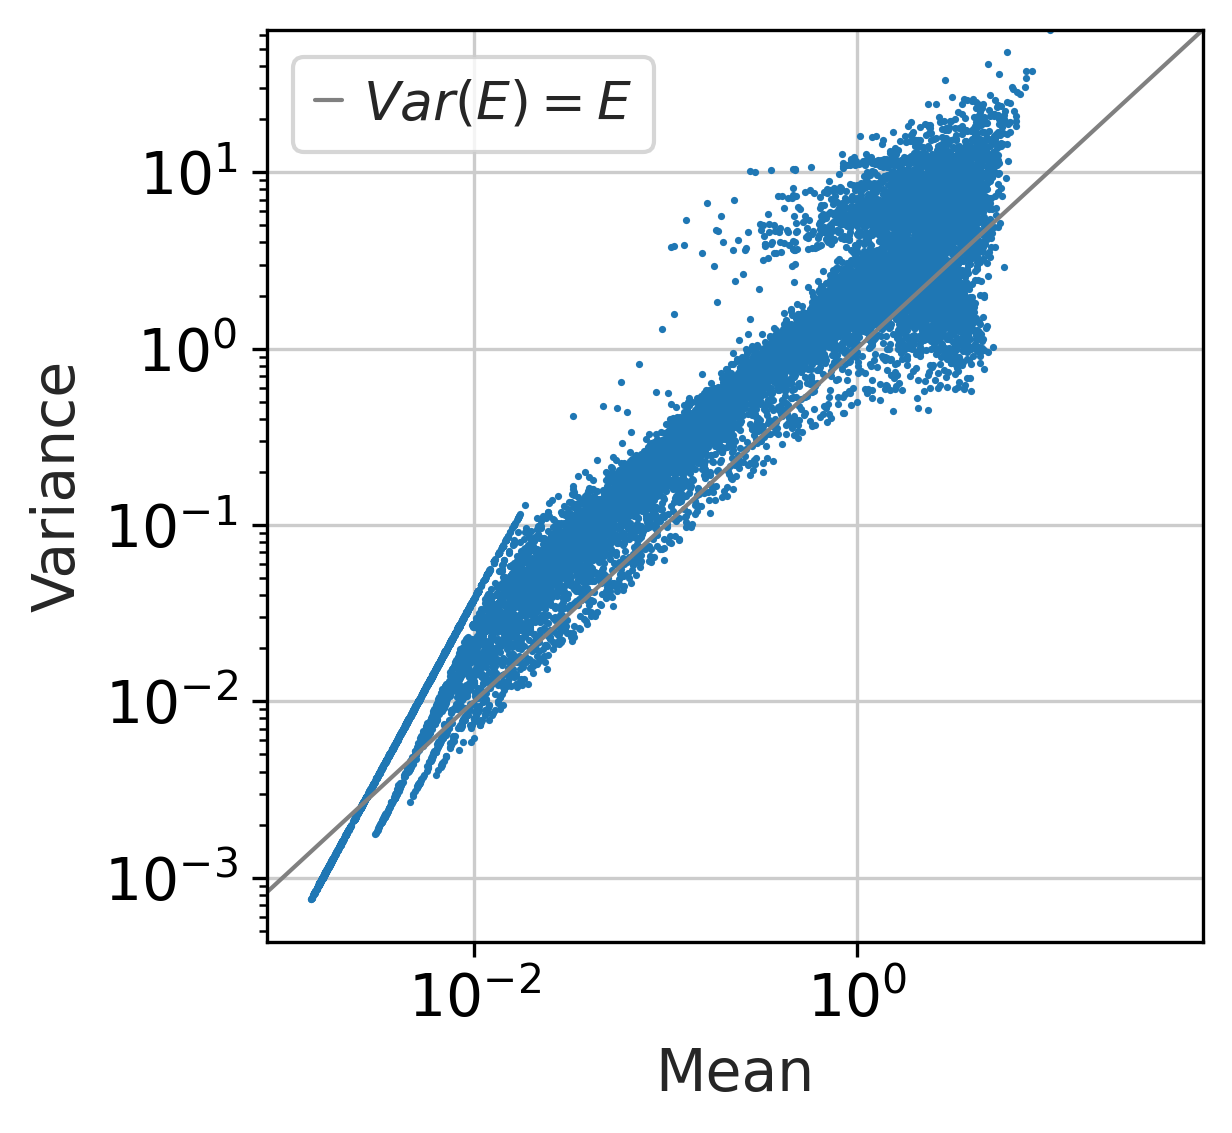

In [ ]:
adata_smart = adata_smart_raw.copy()
sc.pp.normalize_total(adata_smart)
sc.pp.log1p(adata_smart)
sc.pp.normalize_total(adata_smart)
mean_var_plot(adata_smart, log=True)

В данном случае у высокоэкспрессируемых генов наблюдается сначала андердисперсия, а потом овердисперсия. Это еще хуже, чем у предыдущих трансформациях.

#### Вывод

Ни один из простых методов трансформаций не показал себя. Все равно остается техническая дисперсия. Лучше всего показали себя трансформации: log + CP10k, sqrt + CP10k.

### Задание 2

Постройте постройте аналогичный заданию из занятия боксплот с распределением квардарат коэффециента корреляции между экспрессией гена и глубиной секвенирования клетки, только добавьте туда также и корреляцию для остатков регрессии SCTransform (и Analytic Pearson residuals). Есть ли при таких трансформациях зависимость между глубиной секвенирования клетки и экспрессией генов?

### Решение

In [ ]:
adata = adata_smart_raw.copy()

In [ ]:
adata = adata[:, adata.X.A.sum(axis=0)!=0]

In [ ]:
from scipy.stats import pearsonr

adata.obs["total_UMI"] = adata.X.A.sum(axis=1)
n_UMIs = np.array(adata.obs["total_UMI"])

In [ ]:
adata_PF = sc.pp.normalize_total(adata, copy=True)
adata_log1pPF = sc.pp.log1p(adata_PF, copy=True)
adata_PFlog1pPF = sc.pp.normalize_total(adata_log1pPF, copy=True)

results_r2 = pd.DataFrame({
    "PF" : [pearsonr(
        adata_PF[:, gene].X.A.T[0], n_UMIs
    )[0] ** 2 for gene in adata.var_names],
    "log1pPF" : [pearsonr(
        adata_log1pPF[:, gene].X.A.T[0], n_UMIs
    )[0] ** 2 for gene in adata.var_names],
    "PFlog1pPF" : [pearsonr(
        adata_PFlog1pPF[:, gene].X.A.T[0], n_UMIs
    )[0] ** 2 for gene in adata.var_names]
}, index=adata.var_names)

In [ ]:
results_r2_new = results_r2.dropna()

In [ ]:
adata_Pearson = sc.experimental.pp.normalize_pearson_residuals(adata, theta = 7.7, copy=True)

In [ ]:
results_r2_new["Pearson"] = [pearsonr(adata_Pearson[:, gene].X.T[0], n_UMIs)[0] ** 2 for gene in adata.var_names]

In [ ]:
import rpy2.robjects as ro

ro.globalenv["adata_counts"] = adata.copy()
ro.r('SCT.results <- sctransform::vst(assay(adata_counts), vst.flavor="v2")')
var_SCT = ro.r("SCT.results$gene_attr")
SCT = ro.r("SCT.results$y")
cells_SCT = ro.r("SCT.results$cells_step1")

adata_SCT = adata.copy()
adata_SCT = adata_SCT[:, var_SCT.index]
adata_SCT.layers["SCTransform"] = SCT.T

  |======================================================================| 100%


  |======================================================================| 100%


In [ ]:
results_r2_new["SCT"] = [pearsonr(adata_SCT.layers["SCTransform"].T[0], n_UMIs)[0] ** 2 for gene in adata.var_names]

In [ ]:
results_r2_new

,PF,log1pPF,PFlog1pPF,Pearson,SCT
AL627309.1,0.000068,0.000089,0.000035,0.000063,0.000057
AL669831.5,0.001365,0.002177,0.000757,0.001361,0.000057
LINC00115,0.002699,0.003453,0.001467,0.002562,0.000057
FAM41C,0.000044,0.000135,0.000008,0.000053,0.000057
NOC2L,0.002973,0.006633,0.000862,0.002828,0.000057
...,...,...,...,...,...
AL021707.3,0.000016,0.000012,0.000010,0.000025,0.000057
FAM83F,0.000716,0.000774,0.000683,0.000649,0.000057
BX324167.1,0.000059,0.000071,0.000015,0.000054,0.000057
CU633906.2,0.000165,0.000215,0.000105,0.000202,0.000057


[None, None, None, None, None, None, None, None, None, None]

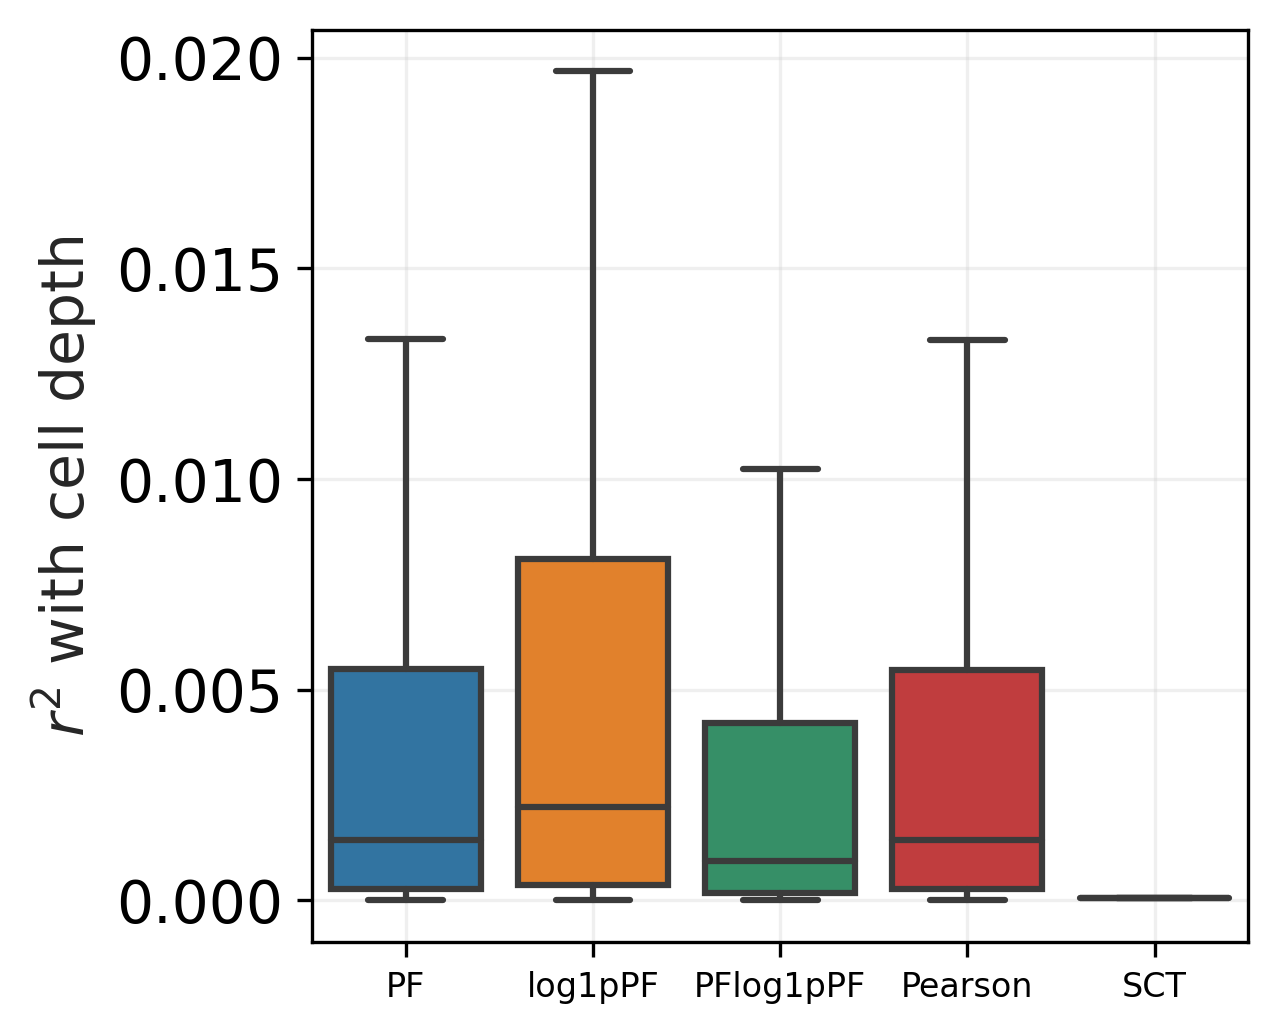

In [ ]:
ax = sns.boxplot(data=results_r2_new, showfliers=False)
ax.set_ylabel("$r^2$ with cell depth")
ax.grid(alpha=0.3)
plt.setp(ax.get_xticklabels(), fontsize=8)

На графике можно увидеть, что SCTransform имеет самое маленькое значение корреляции Пирсона. То есть SCTransform лучше всего справляется с нормализацией и стабилизацией дисперссии данных Smart-seq2.